<a href="https://colab.research.google.com/github/Joey1211/AH2179_AIcourse/blob/main/exercise_5_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

## Data preparation

In [ ]:
import numpy as np
import pandas as pd
import os, sys, warnings
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 50)
np.set_printoptions(linewidth=160, suppress=True, edgeitems=4)

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)


In [ ]:
df_train_raw = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")
evaluation_df = pd.read_csv("evaluation_dataset_exercise_5_clustering_highway_traffic.csv",sep=";")

display(df_train_raw.head(3))
display(df_eval_raw.head(3))


,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26


,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20220108,00:00:00,00:05:00,0,16.74,35
1,"E4S 56,780",20220108,00:05:00,00:10:00,1,17.57,29
2,"E4S 56,780",20220108,00:10:00,00:15:00,2,16.94,32


In [ ]:
# Sort the DataFrame 'df_train_raw' by columns "Date" and "Interval_5"
df_train_raw.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(df_train_raw[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = df_train_raw.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

[[ 39.  18.  26.  52. ...  43.  32.  39.  34.]
 [ 30.  32.  27.  37. ...  55.  44.  41.  39.]
 [ 36.  44.  52.  61. ...  33.  50.  45.  23.]
 [ 41.  36.  37.  31. ...  35.  28.  43.  18.]
 ...
 [ 26.  19.  29.  24. ...  43.  27.  36.  34.]
 [ 20.  34.  31.  21. ...  37.  38.  42.  36.]
 [ 36.  40.  25.  45. ...  46.  38.  56.  35.]
 [ 33.  32.  34.  24. ...  87. 130. 129. 117.]]


## Missing values and outliers


In [ ]:

print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

number of nans 277
rate of nans 0.0026350837138508373


(288,)


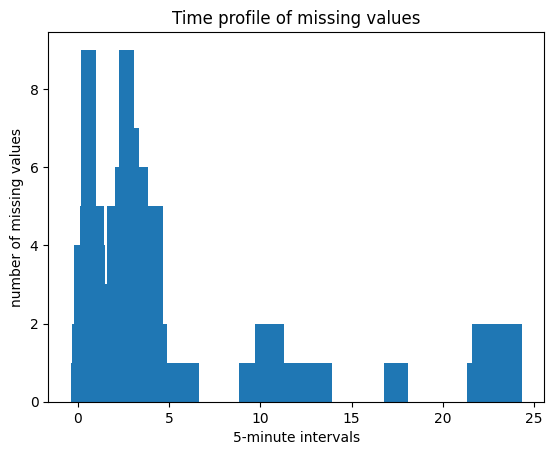

In [ ]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('5-minute intervals')
ax.set_title('Time profile of missing values')

plt.show()

In [ ]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


In [ ]:
days_not_nans = days[nans_per_day == 0]
vectorized_day_dataset_no_nans = vectorized_day_dataset[nans_per_day == 0]

## Clustering and internal evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
vectorized_day_dataset_no_nans_std = scaler.fit_transform(vectorized_day_dataset_no_nans)

print("After standard:", vectorized_day_dataset_no_nans_std.shape)


After standard: (337, 288)


### K-Means

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

rows_kmeans_full = []
for k in range(4, 13):
    kmeans_t = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels_t = kmeans_t.fit_predict(vectorized_day_dataset_no_nans_std)

    try:
        sil_t = silhouette_score(vectorized_day_dataset_no_nans_std, labels_t)
    except Exception:
        sil_t = np.nan
    try:
        ch_t = calinski_harabasz_score(vectorized_day_dataset_no_nans_std, labels_t)
    except Exception:
        ch_t = np.nan
    try:
        db_t = davies_bouldin_score(vectorized_day_dataset_no_nans_std, labels_t)
    except Exception:
        db_t = np.nan

    rows_kmeans_full.append({
        "method": "kmeans",
        "n_clusters": k,
        "silhouette": sil_t,
        "calinski_harabasz": ch_t,
        "davies_bouldin": db_t
    })

df_kmeans_full = pd.DataFrame(rows_kmeans_full)

df_kmeans_full["rank_sil"] = df_kmeans_full["silhouette"].rank(ascending=False, method="min")
df_kmeans_full["rank_ch"]  = df_kmeans_full["calinski_harabasz"].rank(ascending=False, method="min")
df_kmeans_full["rank_db"]  = df_kmeans_full["davies_bouldin"].rank(ascending=True,  method="min")
df_kmeans_full["rank_sum"] = df_kmeans_full[["rank_sil","rank_ch","rank_db"]].sum(axis=1)

print("All KMeans internal-evaluation results (ascending by k):")
display(df_kmeans_full.sort_values("n_clusters").reset_index(drop=True))

print("Top-5 by combined rank_sum (lower is better):")
display(df_kmeans_full.sort_values(["rank_sum","silhouette","calinski_harabasz","davies_bouldin"]).head(5))

best_row = df_kmeans_full.sort_values(["rank_sum","silhouette","calinski_harabasz","davies_bouldin"]).iloc[0]
best_k = int(best_row["n_clusters"])
print(f"Best k by combined rank_sum: k={best_k}")



All KMeans internal-evaluation results (ascending by k):


,method,n_clusters,silhouette,calinski_harabasz,davies_bouldin,rank_sil,rank_ch,rank_db,rank_sum
0,kmeans,4,0.222777,79.778055,1.342161,1.0,1.0,1.0,3.0
1,kmeans,5,0.211918,74.357975,1.511708,2.0,2.0,2.0,6.0
2,kmeans,6,0.205394,65.840379,1.581597,3.0,3.0,3.0,9.0
3,kmeans,7,0.173036,59.397354,1.653621,4.0,4.0,4.0,12.0
4,kmeans,8,0.165054,54.031498,1.858397,5.0,5.0,7.0,17.0
5,kmeans,9,0.152953,50.139513,1.832222,6.0,6.0,6.0,18.0
6,kmeans,10,0.138864,47.664636,1.931290,7.0,7.0,8.0,22.0
7,kmeans,11,0.132531,45.512199,1.951385,9.0,8.0,9.0,26.0
8,kmeans,12,0.135674,43.915549,1.755384,8.0,9.0,5.0,22.0


Top-5 by combined rank_sum (lower is better):


,method,n_clusters,silhouette,calinski_harabasz,davies_bouldin,rank_sil,rank_ch,rank_db,rank_sum
0,kmeans,4,0.222777,79.778055,1.342161,1.0,1.0,1.0,3.0
1,kmeans,5,0.211918,74.357975,1.511708,2.0,2.0,2.0,6.0
2,kmeans,6,0.205394,65.840379,1.581597,3.0,3.0,3.0,9.0
3,kmeans,7,0.173036,59.397354,1.653621,4.0,4.0,4.0,12.0
4,kmeans,8,0.165054,54.031498,1.858397,5.0,5.0,7.0,17.0


Best k by combined rank_sum: k=4


### Agglomerative

All Agglomerative internal-evaluation results (ascending by k, then linkage):


,method,n_clusters,linkage,silhouette,calinski_harabasz,davies_bouldin,rank_sil,rank_ch,rank_db,rank_sum
0,agglomerative,4,average,0.398869,13.886043,0.452631,1.0,24.0,1.0,26.0
1,agglomerative,4,complete,0.197009,47.334714,1.172324,7.0,7.0,13.0,27.0
2,agglomerative,4,ward,0.203784,72.378570,1.332925,6.0,1.0,19.0,26.0
3,agglomerative,5,average,0.299772,11.276053,0.474603,2.0,25.0,2.0,29.0
4,agglomerative,5,complete,0.176003,41.780601,1.296332,14.0,11.0,17.0,42.0
5,agglomerative,5,ward,0.191519,70.023202,1.596187,9.0,2.0,20.0,31.0
6,agglomerative,6,average,0.281153,9.658712,0.493143,3.0,26.0,3.0,32.0
7,agglomerative,6,complete,0.173086,34.595887,1.134724,15.0,15.0,12.0,42.0
8,agglomerative,6,ward,0.179807,63.474866,1.614702,12.0,3.0,21.0,36.0
9,agglomerative,7,average,0.216689,9.148266,0.693253,4.0,27.0,4.0,35.0


Top-10 by combined rank_sum (lower is better):


,method,n_clusters,linkage,silhouette,calinski_harabasz,davies_bouldin,rank_sil,rank_ch,rank_db,rank_sum
0,agglomerative,4,ward,0.203784,72.378570,1.332925,6.0,1.0,19.0,26.0
1,agglomerative,4,average,0.398869,13.886043,0.452631,1.0,24.0,1.0,26.0
2,agglomerative,4,complete,0.197009,47.334714,1.172324,7.0,7.0,13.0,27.0
13,agglomerative,8,average,0.212152,21.755476,0.767624,5.0,19.0,5.0,29.0
4,agglomerative,5,average,0.299772,11.276053,0.474603,2.0,25.0,2.0,29.0
3,agglomerative,5,ward,0.191519,70.023202,1.596187,9.0,2.0,20.0,31.0
7,agglomerative,6,average,0.281153,9.658712,0.493143,3.0,26.0,3.0,32.0
16,agglomerative,9,average,0.196372,20.001810,0.816447,8.0,20.0,6.0,34.0
10,agglomerative,7,average,0.216689,9.148266,0.693253,4.0,27.0,4.0,35.0
6,agglomerative,6,ward,0.179807,63.474866,1.614702,12.0,3.0,21.0,36.0


Best Agglomerative setting by combined rank_sum: k=4, linkage=ward


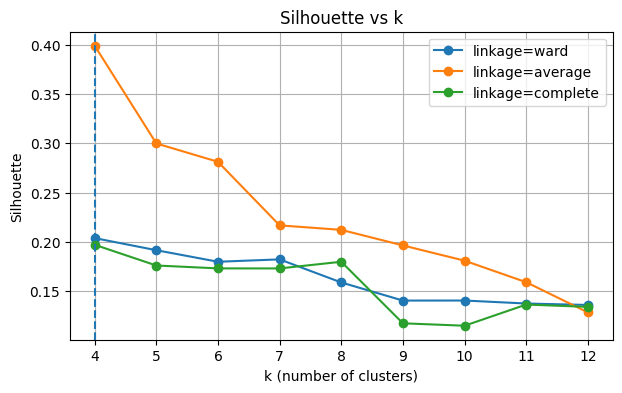

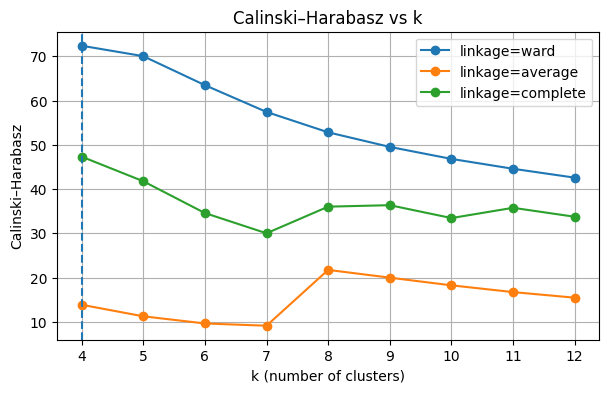

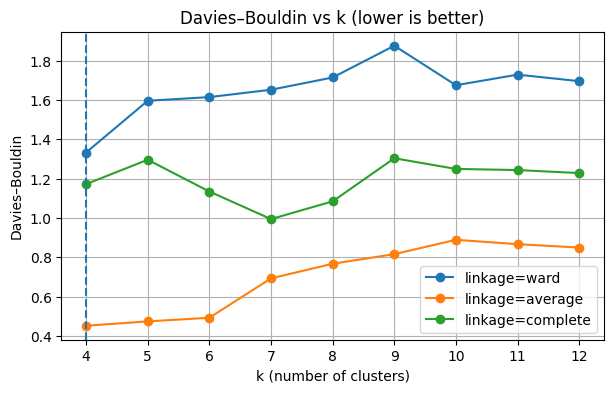

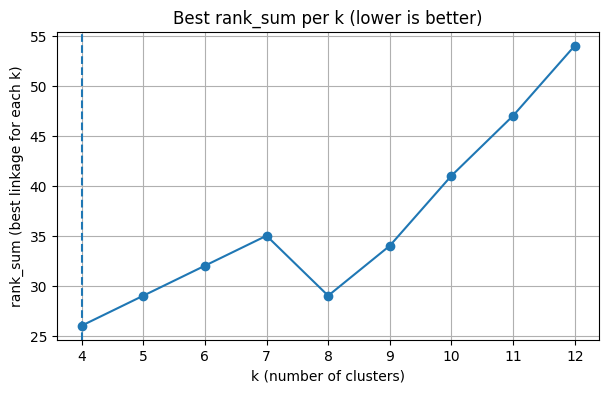

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

rows_agglo_full = []
linkages = ["ward", "average", "complete"]

for k in range(4, 13):
    for link in linkages:
        try:
            ag = AgglomerativeClustering(n_clusters=k, linkage=link)
            labels_t = ag.fit_predict(vectorized_day_dataset_no_nans_std)
            try:
                sil_t = silhouette_score(vectorized_day_dataset_no_nans_std, labels_t)
            except Exception:
                sil_t = np.nan
            try:
                ch_t = calinski_harabasz_score(vectorized_day_dataset_no_nans_std, labels_t)
            except Exception:
                ch_t = np.nan
            try:
                db_t = davies_bouldin_score(vectorized_day_dataset_no_nans_std, labels_t)
            except Exception:
                db_t = np.nan

            rows_agglo_full.append({
                "method": "agglomerative",
                "n_clusters": k,
                "linkage": link,
                "silhouette": sil_t,
                "calinski_harabasz": ch_t,
                "davies_bouldin": db_t
            })
        except Exception as e:

            rows_agglo_full.append({
                "method": "agglomerative",
                "n_clusters": k,
                "linkage": link,
                "silhouette": np.nan,
                "calinski_harabasz": np.nan,
                "davies_bouldin": np.nan
            })

df_agglo_full = pd.DataFrame(rows_agglo_full)

df_agglo_full["rank_sil"] = df_agglo_full["silhouette"].rank(ascending=False, method="min")
df_agglo_full["rank_ch"]  = df_agglo_full["calinski_harabasz"].rank(ascending=False, method="min")
df_agglo_full["rank_db"]  = df_agglo_full["davies_bouldin"].rank(ascending=True,  method="min")
df_agglo_full["rank_sum"] = df_agglo_full[["rank_sil","rank_ch","rank_db"]].sum(axis=1)

print("All Agglomerative internal-evaluation results (ascending by k, then linkage):")
display(df_agglo_full.sort_values(["n_clusters","linkage"]).reset_index(drop=True))

print("Top-10 by combined rank_sum (lower is better):")
display(df_agglo_full.sort_values(["rank_sum","silhouette","calinski_harabasz","davies_bouldin"]).head(10))

best_row_agg = df_agglo_full.sort_values(
    ["rank_sum","silhouette","calinski_harabasz","davies_bouldin"]
).iloc[0]
best_k_agg = int(best_row_agg["n_clusters"])
best_linkage_agg = best_row_agg["linkage"]
print(f"Best Agglomerative setting by combined rank_sum: k={best_k_agg}, linkage={best_linkage_agg}")

# ------- 绘图：按 linkage 分面画三指标 vs k -------
for metric_col, ttl, ylab in [
    ("silhouette", "Silhouette vs k", "Silhouette"),
    ("calinski_harabasz", "Calinski–Harabasz vs k", "Calinski–Harabasz"),
    ("davies_bouldin", "Davies–Bouldin vs k (lower is better)", "Davies–Bouldin"),
]:
    plt.figure(figsize=(7,4))
    for link in linkages:
        sub = df_agglo_full[df_agglo_full["linkage"]==link].sort_values("n_clusters")
        plt.plot(sub["n_clusters"].values, sub[metric_col].values, marker="o", label=f"linkage={link}")
    plt.title(ttl)
    plt.xlabel("k (number of clusters)")
    plt.ylabel(ylab)
    plt.grid(True)
    # 标注综合最佳的垂线
    plt.axvline(best_k_agg, linestyle="--")
    plt.legend()
    plt.show()

# ------- rank_sum vs k（对每个 k 取该 k 下最优 linkage 的 rank_sum，便于横向看 k 的趋势）-------
best_per_k = (
    df_agglo_full.sort_values(["n_clusters","rank_sum"])
    .groupby("n_clusters", as_index=False).first()
    .loc[:, ["n_clusters","rank_sum"]]
)
plt.figure(figsize=(7,4))
plt.plot(best_per_k["n_clusters"].values, best_per_k["rank_sum"].values, marker="o")
plt.title("Best rank_sum per k (lower is better)")
plt.xlabel("k (number of clusters)")
plt.ylabel("rank_sum (best linkage for each k)")
plt.grid(True)
plt.axvline(best_k_agg, linestyle="--")
plt.show()


### Gaussian Mixture Model (GMM)

All GMM internal-evaluation results (ascending by k, then covariance_type):


,method,n_components,covariance_type,silhouette,calinski_harabasz,davies_bouldin,rank_sil,rank_ch,rank_db,rank_sum
0,gmm,4,diag,0.213136,74.560889,1.860338,1.0,2.0,15.0,18.0
1,gmm,4,full,0.211012,75.544228,1.807165,3.0,1.0,12.0,16.0
2,gmm,5,diag,0.202651,72.587762,1.544680,4.0,4.0,4.0,12.0
3,gmm,5,full,0.211918,74.357975,1.511708,2.0,3.0,2.0,7.0
4,gmm,6,diag,0.195329,64.815548,1.520685,6.0,6.0,3.0,15.0
5,gmm,6,full,0.201876,65.340988,1.494905,5.0,5.0,1.0,11.0
6,gmm,7,diag,0.180231,57.674588,1.697496,7.0,8.0,6.0,21.0
7,gmm,7,full,0.177018,58.294183,1.677221,8.0,7.0,5.0,20.0
8,gmm,8,diag,0.156498,52.596858,1.895038,10.0,10.0,16.0,36.0
9,gmm,8,full,0.165054,54.031498,1.858397,9.0,9.0,14.0,32.0


Top-10 by combined rank_sum (lower is better):


,method,n_components,covariance_type,silhouette,calinski_harabasz,davies_bouldin,rank_sil,rank_ch,rank_db,rank_sum
3,gmm,5,full,0.211918,74.357975,1.511708,2.0,3.0,2.0,7.0
5,gmm,6,full,0.201876,65.340988,1.494905,5.0,5.0,1.0,11.0
2,gmm,5,diag,0.202651,72.587762,1.544680,4.0,4.0,4.0,12.0
4,gmm,6,diag,0.195329,64.815548,1.520685,6.0,6.0,3.0,15.0
1,gmm,4,full,0.211012,75.544228,1.807165,3.0,1.0,12.0,16.0
0,gmm,4,diag,0.213136,74.560889,1.860338,1.0,2.0,15.0,18.0
7,gmm,7,full,0.177018,58.294183,1.677221,8.0,7.0,5.0,20.0
6,gmm,7,diag,0.180231,57.674588,1.697496,7.0,8.0,6.0,21.0
9,gmm,8,full,0.165054,54.031498,1.858397,9.0,9.0,14.0,32.0
15,gmm,11,full,0.145117,45.462079,1.769338,12.0,14.0,8.0,34.0


Best GMM setting by combined rank_sum: k=5, covariance_type=full


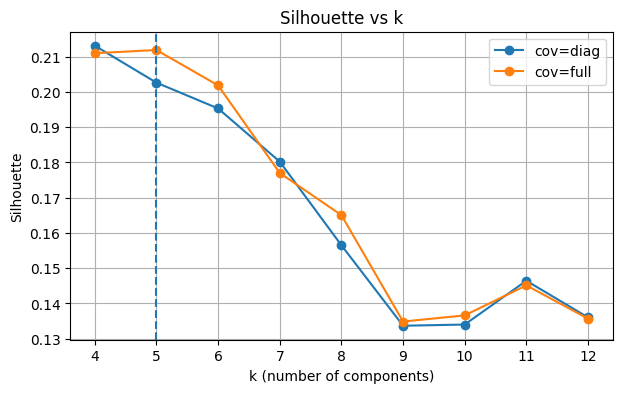

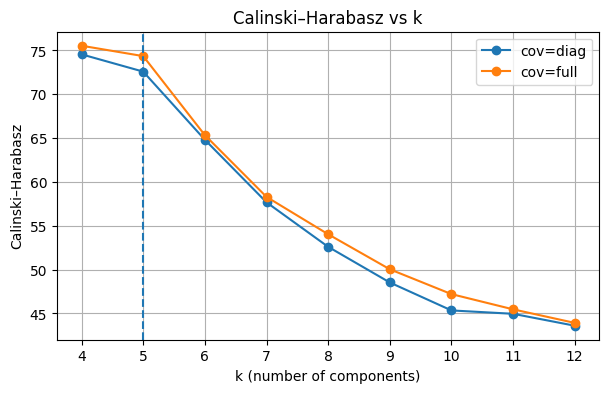

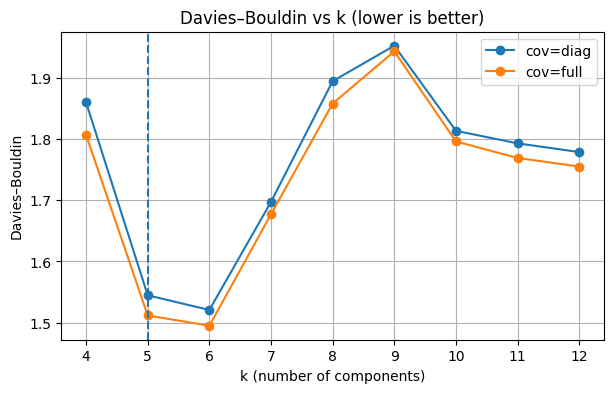

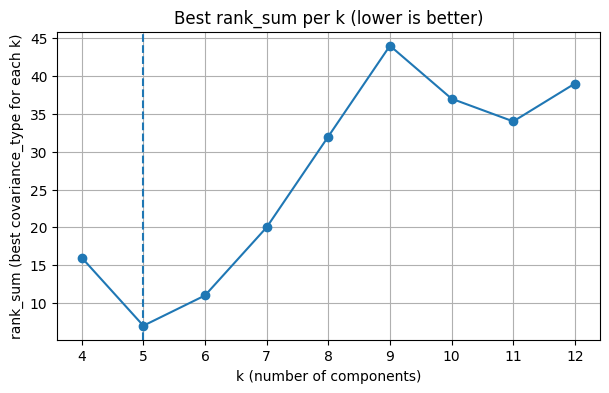

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

rows_gmm_full = []
cov_types = ["diag", "full"]

for k in range(4, 13):
    for cov in cov_types:
        try:
            gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=0)
            gmm.fit(vectorized_day_dataset_no_nans_std)
            labels_t = gmm.predict(vectorized_day_dataset_no_nans_std)

            try:
                sil_t = silhouette_score(vectorized_day_dataset_no_nans_std, labels_t)
            except Exception:
                sil_t = np.nan
            try:
                ch_t = calinski_harabasz_score(vectorized_day_dataset_no_nans_std, labels_t)
            except Exception:
                ch_t = np.nan
            try:
                db_t = davies_bouldin_score(vectorized_day_dataset_no_nans_std, labels_t)
            except Exception:
                db_t = np.nan

            rows_gmm_full.append({
                "method": "gmm",
                "n_components": k,
                "covariance_type": cov,
                "silhouette": sil_t,
                "calinski_harabasz": ch_t,
                "davies_bouldin": db_t
            })
        except Exception:
            rows_gmm_full.append({
                "method": "gmm",
                "n_components": k,
                "covariance_type": cov,
                "silhouette": np.nan,
                "calinski_harabasz": np.nan,
                "davies_bouldin": np.nan
            })

df_gmm_full = pd.DataFrame(rows_gmm_full)

df_gmm_full["rank_sil"] = df_gmm_full["silhouette"].rank(ascending=False, method="min")
df_gmm_full["rank_ch"]  = df_gmm_full["calinski_harabasz"].rank(ascending=False, method="min")
df_gmm_full["rank_db"]  = df_gmm_full["davies_bouldin"].rank(ascending=True,  method="min")
df_gmm_full["rank_sum"] = df_gmm_full[["rank_sil","rank_ch","rank_db"]].sum(axis=1)

print("All GMM internal-evaluation results (ascending by k, then covariance_type):")
display(df_gmm_full.sort_values(["n_components","covariance_type"]).reset_index(drop=True))

print("Top-10 by combined rank_sum (lower is better):")
display(df_gmm_full.sort_values(["rank_sum","silhouette","calinski_harabasz","davies_bouldin"]).head(10))

best_row_gmm = df_gmm_full.sort_values(
    ["rank_sum","silhouette","calinski_harabasz","davies_bouldin"]
).iloc[0]
best_k_gmm = int(best_row_gmm["n_components"])
best_cov_gmm = best_row_gmm["covariance_type"]
print(f"Best GMM setting by combined rank_sum: k={best_k_gmm}, covariance_type={best_cov_gmm}")

for metric_col, ttl, ylab in [
    ("silhouette", "Silhouette vs k", "Silhouette"),
    ("calinski_harabasz", "Calinski–Harabasz vs k", "Calinski–Harabasz"),
    ("davies_bouldin", "Davies–Bouldin vs k (lower is better)", "Davies–Bouldin"),
]:
    plt.figure(figsize=(7,4))
    for cov in cov_types:
        sub = df_gmm_full[df_gmm_full["covariance_type"]==cov].sort_values("n_components")
        plt.plot(sub["n_components"].values, sub[metric_col].values, marker="o", label=f"cov={cov}")
    plt.title(ttl)
    plt.xlabel("k (number of components)")
    plt.ylabel(ylab)
    plt.grid(True)

    plt.axvline(best_k_gmm, linestyle="--")
    plt.legend()
    plt.show()

best_per_k_gmm = (
    df_gmm_full.sort_values(["n_components","rank_sum"])
    .groupby("n_components", as_index=False).first()
    .loc[:, ["n_components","rank_sum"]]
)
plt.figure(figsize=(7,4))
plt.plot(best_per_k_gmm["n_components"].values, best_per_k_gmm["rank_sum"].values, marker="o")
plt.title("Best rank_sum per k (lower is better)")
plt.xlabel("k (number of components)")
plt.ylabel("rank_sum (best covariance_type for each k)")
plt.grid(True)
plt.axvline(best_k_gmm, linestyle="--")
plt.show()


### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import pandas as pd

eps_list = [400, 450, 500, 550, 600]
min_samples_list = [2, 3, 5]

rows = []
for eps in eps_list:
    for ms in min_samples_list:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(vectorized_day_dataset_no_nans)
        uniq = np.unique(labels[labels >= 0])
        n_clusters = len(uniq)
        n_noise = int(np.sum(labels == -1))

        if n_clusters >= 2:
            mask = labels >= 0
            try:
                sil = silhouette_score(vectorized_day_dataset_no_nans[mask], labels[mask])
            except Exception:
                sil = np.nan
            try:
                ch = calinski_harabasz_score(vectorized_day_dataset_no_nans[mask], labels[mask])
            except Exception:
                ch = np.nan
            try:
                dbi = davies_bouldin_score(vectorized_day_dataset_no_nans[mask], labels[mask])
            except Exception:
                dbi = np.nan
        else:
            sil, ch, dbi = np.nan, np.nan, np.nan

        rows.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil,
            "calinski_harabasz": ch,
            "davies_bouldin": dbi
        })

df_dbscan_tune = pd.DataFrame(rows)
print("DBSCAN parameter sweep (raw data, eps around 500):")
display(df_dbscan_tune.sort_values(["eps","min_samples"]).reset_index(drop=True))


DBSCAN parameter sweep (raw data, eps around 500):


,eps,min_samples,n_clusters,n_noise,silhouette,calinski_harabasz,davies_bouldin
0,400,2,12,294,0.222455,19.213692,1.111409
1,400,3,8,302,0.256296,24.201080,1.135688
2,400,5,2,325,0.297115,7.343227,1.132422
3,450,2,16,238,0.152819,24.048462,1.222039
4,450,3,10,250,0.220498,27.713900,1.178376
5,450,5,6,275,0.379240,38.683406,1.091361
6,500,2,6,167,0.327729,109.922957,1.052498
7,500,3,6,167,0.327729,109.922957,1.052498
8,500,5,5,182,0.355637,124.973015,1.039452
9,550,2,5,118,-0.145601,2.256720,1.451951


## Internal Evaluation
| method        | params                 | silhouette | calinski_harabasz | davies_bouldin |
|---------------|------------------------|------------|-------------------|----------------|
| kmeans        | k=4                    | 0.223      | 79.78             | 1.34           |
| agglomerative | k=4, link=ward         | 0.204      | 72.38             | 1.33           |
| gmm           | k=5, cov=full          | 0.212      | 74.36             | 1.51           |
| dbscan        | eps=500, min_samples=2 | **0.328**  | **109.92**        | **1.05**       |


## External Evaluation

In [ ]:
df_eval = evaluation_df.sort_values(["Date", "Interval_5"])
days_eval = np.unique(df_eval[['Date']].values.ravel())
ndays_eval = len(days_eval)
day_subsets_eval = df_eval.groupby(["Date"])

nintvals = 288
vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
vectorized_day_dataset_eval.fill(np.nan)

for i in range(0, ndays_eval):
    df_t = day_subsets_eval.get_group(days_eval[i])
    for j in range(len(df_t)):
        df_t = day_subsets_eval.get_group(days_eval[i])
        vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# remove days with NaN
nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), axis=1)
days_eval_not_nans = days_eval[nans_per_day_eval == 0]
vectorized_day_dataset_eval_no_nans = vectorized_day_dataset_eval[nans_per_day_eval == 0]

print("Evaluation dataset shape (after removing NaN days):", vectorized_day_dataset_eval_no_nans.shape)

Evaluation dataset shape (after removing NaN days): (69, 288)


In [41]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error

history_len = 5
eps_for_mape = 1e-6

def stepwise_eval_with_centroids(centers_std: np.ndarray, X_eval_std: np.ndarray, history_len: int = 5):

    preds_all, trues_all = [], []
    nintvals = centers_std.shape[1]

    for d in range(X_eval_std.shape[0]):
        x = X_eval_std[d]

        for j in range(history_len, nintvals - 1):
            past = x[j-history_len+1:j+1]

            dists = []
            for c in centers_std:
                ref = c[:j+1]
                if ref.shape[0] < history_len:
                    dists.append(np.inf)
                else:
                    ref_tail = ref[-history_len:]
                    dists.append(np.linalg.norm(ref_tail - past))
            best = int(np.argmin(dists))
            y_pred = centers_std[best][j+1]
            y_true = x[j+1]
            preds_all.append(y_pred)
            trues_all.append(y_true)

    preds_all = np.array(preds_all)
    trues_all = np.array(trues_all)
    mae = mean_absolute_error(trues_all, preds_all)
    mape = float(np.mean(np.abs((trues_all - preds_all) / np.maximum(np.abs(trues_all), eps_for_mape))))
    return mae, mape

X_eval_std = scaler.transform(vectorized_day_dataset_eval_no_nans)

# --- 1) KMeans (k=4) ---
kmeans_model = KMeans(n_clusters=4, n_init=10, random_state=0).fit(vectorized_day_dataset_no_nans_std)
centers_kmeans_std = kmeans_model.cluster_centers_
mae_km, mape_km = stepwise_eval_with_centroids(centers_kmeans_std, X_eval_std, history_len=history_len)

# --- 2) Agglomerative (k=4, linkage=ward) ---
agg_model = AgglomerativeClustering(n_clusters=4, linkage="ward")
labels_agg = agg_model.fit_predict(vectorized_day_dataset_no_nans_std)

centers_agg_std = np.vstack([vectorized_day_dataset_no_nans_std[labels_agg==i].mean(axis=0) for i in np.unique(labels_agg)])
mae_ag, mape_ag = stepwise_eval_with_centroids(centers_agg_std, X_eval_std, history_len=history_len)

# --- 3) GMM (k=5, cov=full) ---
gmm_model = GaussianMixture(n_components=5, covariance_type="full", random_state=0)
gmm_model.fit(vectorized_day_dataset_no_nans_std)
labels_gmm = gmm_model.predict(vectorized_day_dataset_no_nans_std)
centers_gmm_std = np.vstack([vectorized_day_dataset_no_nans_std[labels_gmm==i].mean(axis=0) for i in np.unique(labels_gmm)])
mae_gm, mape_gm = stepwise_eval_with_centroids(centers_gmm_std, X_eval_std, history_len=history_len)

# --- 4) DBSCAN  ---
db_model = DBSCAN(eps=500, min_samples=2).fit(vectorized_day_dataset_no_nans)
labels_db = db_model.labels_
valid = np.unique(labels_db[labels_db>=0])
results = []
if len(valid) >= 2:

    centers_db_raw = np.vstack([
        vectorized_day_dataset_no_nans[labels_db==i].mean(axis=0) for i in valid
    ])
    centers_db_std = scaler.transform(centers_db_raw)
    mae_db, mape_db = stepwise_eval_with_centroids(centers_db_std, X_eval_std, history_len=history_len)
else:
    mae_db, mape_db = np.nan, np.nan

df_stepwise_compare = pd.DataFrame([
    {"method":"kmeans",        "params":"k=4",              "MAE":mae_km, "MAPE":mape_km},
    {"method":"agglomerative", "params":"k=4, link=ward",   "MAE":mae_ag, "MAPE":mape_ag},
    {"method":"gmm",           "params":"k=5, cov=full",    "MAE":mae_gm, "MAPE":mape_gm},
    {"method":"dbscan",        "params":"eps=500, ms=2",    "MAE":mae_db, "MAPE":mape_db},
])

print("Stepwise external evaluation (MAE/MAPE) across models:")
display(df_stepwise_compare.sort_values("MAE"))


Stepwise external evaluation (MAE/MAPE) across models:


,method,params,MAE,MAPE
2,gmm,"k=5, cov=full",0.429459,2.141459
3,dbscan,"eps=500, ms=2",0.436278,2.375280
1,agglomerative,"k=4, link=ward",0.443484,1.974418
0,kmeans,k=4,0.445012,2.142849


| method        | params                 | MAE    | MAPE   | silhouette | calinski_harabasz | davies_bouldin |
|---------------|------------------------|--------|--------|------------|-------------------|----------------|
| kmeans        | k=4                    | 0.445  | 2.14   | 0.223      | 79.78             | 1.34           |
| agglomerative | k=4, link=ward         | 0.443  | **1.97** | 0.204      | 72.38             | 1.33           |
| gmm           | k=5, cov=full          | **0.429** | 2.14   | 0.212      | 74.36             | 1.51           |
| dbscan        | eps=500, min_samples=2 | 0.436  | 2.38   | **0.328**  | **109.92**        | **1.05**       |


For internal evaluation, DBSCAN (eps=500, min_samples=2) is the best choice, as it achieved the highest Silhouette (0.328), the highest Calinski–Harabasz (109.92), and the lowest Davies–Bouldin (1.05), showing the clearest and most compact cluster structure.

For external evaluation, GMM (k=5, full) is the best performer, with the lowest MAE (0.429), indicating that its centroids provide the most accurate short-term predictions on the evaluation dataset.

## Visualization

In [47]:
import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



### GMM k=5 full

cluster_id_weekdays_share [111, 12, 106, 6, 1]
cluster_id_weekend_share [0, 54, 0, 45, 2]
111


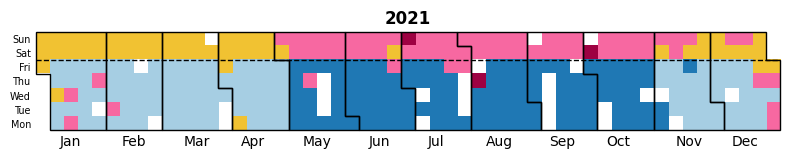

In [52]:
# Fit GMM with k=5, covariance_type=full
from sklearn.mixture import GaussianMixture

gmm_model = GaussianMixture(n_components=5, covariance_type="full", random_state=0)
gmm_model.fit(vectorized_day_dataset_no_nans_std)

# Generate cluster labels
cluster_labels = gmm_model.predict(vectorized_day_dataset_no_nans_std)

# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).


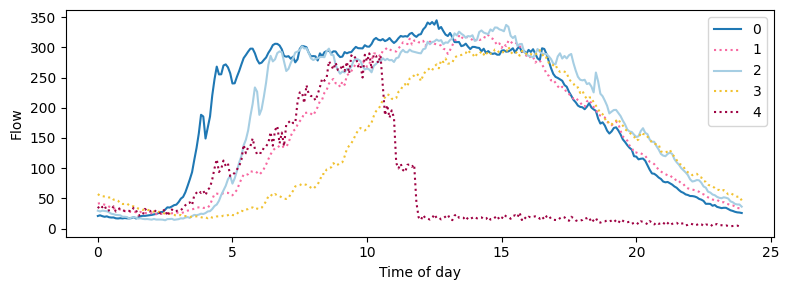

In [53]:
# Initialize empty lists to store centroid data (GMM)
centroids_xx = []                 # x-axis values for centroids
centroids_yy_daytypes = []        # y-axis values for centroids, grouped by day types
cluster_ids = []                  # Cluster IDs (0..k-1 for GMM)

# Iterate through each cluster id produced by GMM
for i in range(0, n_clusters_t):
    # x-axis: hours of the day
    centroids_xx.append(x_axis_hours)

    # centroid in RAW units: average of all days assigned to cluster i
    centroid_yy = list(
        np.nanmean(
            vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :],
            axis=0
        ).transpose()
    )
    centroids_yy_daytypes.append(centroid_yy)

    # store cluster id
    cluster_ids.append(i)

# Plot centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)


### DBSCAN

cluster_id_weekdays_share [2, 37, 3, 32, 14, 148]
cluster_id_weekend_share [44, 0, 35, 0, 0, 22]
111


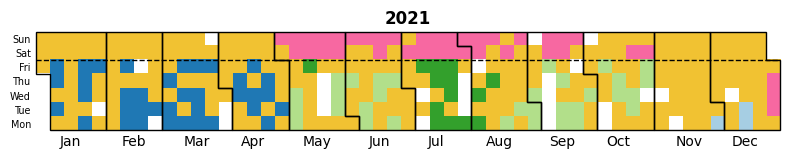

In [54]:
# Fit DBSCAN with eps=500, min_samples=2 on RAW matrix
from sklearn.cluster import DBSCAN
import numpy as np

db_model = DBSCAN(eps=500, min_samples=2)
cluster_labels = db_model.fit_predict(vectorized_day_dataset_no_nans)  # -1 为噪声

# 仅统计非噪声簇数（-1 不算进来）
unique_non_noise = np.unique(cluster_labels[cluster_labels >= 0])
n_clusters_t = len(unique_non_noise)

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(
    days_not_nans,
    cluster_labels,        # 包含 -1 的噪声标签，函数会按映射上色；若不希望显示噪声可先过滤
    n_clusters_t,
    [2021],
    days_colors,
    color_to_cluster,
    save_figure=None
)
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels (including -1 for noise),
# 'n_clusters_t' excludes noise clusters, and 'save_figure' can be None if not saving.


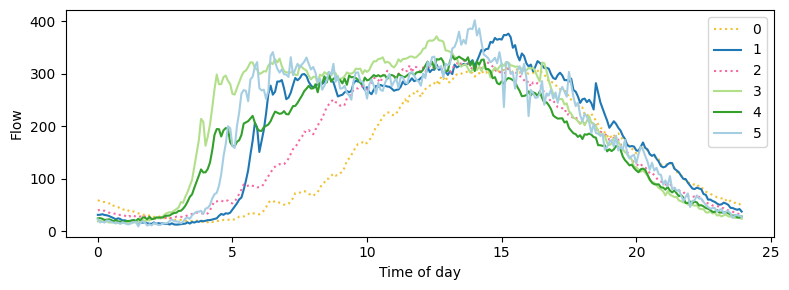

In [55]:
# Initialize empty lists to store centroid data (DBSCAN)
centroids_xx = []                 # x-axis values for centroids
centroids_yy_daytypes = []        # y-axis values for centroids, grouped by day types
cluster_ids = []                  # Use actual DBSCAN labels (exclude noise -1)

# Get non-noise labels explicitly
unique_non_noise = np.unique(cluster_labels[cluster_labels >= 0])

# Iterate through each non-noise cluster label
for lbl in unique_non_noise:
    # x-axis: hours of the day
    centroids_xx.append(x_axis_hours)

    # centroid in RAW units: average of all days assigned to this DBSCAN label
    centroid_yy = list(
        np.nanmean(
            vectorized_day_dataset_no_nans[np.where(cluster_labels == lbl)[0], :],
            axis=0
        ).transpose()
    )
    centroids_yy_daytypes.append(centroid_yy)

    # keep the original DBSCAN cluster label so colors match your calendar
    cluster_ids.append(int(lbl))

# Plot centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)


## Analysis
Looking at the calendar and profile visualizations, the clustering results from GMM (k=5, full covariance) are much clearer and easier to interpret. The five clusters separate the data into meaningful groups: workdays and holidays from November to April, workdays and holidays from May to October, and one cluster that contains only three special days (July 4, August 5, October 2) where traffic flow drops abnormally below 50 after noon, compared to the usual decline from around 350 to 50. This separation reflects seasonal differences and weekday/holiday dynamics in a way that corresponds well with real-world expectations.

By comparison, the DBSCAN clustering appeared chaotic, with clusters scattered randomly across the calendar and no recognizable patterns. This makes it difficult to interpret or connect the results to meaningful day-types.

Based on this analysis, **GMM (k=5, full)** provides the most reasonable and representative clustering of day-types in the dataset.